# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [24]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [25]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [26]:
# TODO: Define your transforms for the training and validation sets

# how many samples per batch to load
batch_size = 16
number_classes = 102

train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(224, scale=(0.1, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomGrayscale(p=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform = validation_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [27]:
'''# Run this to test your data loader

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(iter(train_loader))
imshow(images[0], normalize=True)'''

'# Run this to test your data loader\n\ndef imshow(image, ax=None, title=None, normalize=True):\n    """Imshow for Tensor."""\n    if ax is None:\n        fig, ax = plt.subplots()\n    image = image.numpy().transpose((1, 2, 0))\n\n    if normalize:\n        mean = np.array([0.485, 0.456, 0.406])\n        std = np.array([0.229, 0.224, 0.225])\n        image = std * image + mean\n        image = np.clip(image, 0, 1)\n\n    ax.imshow(image)\n    ax.spines[\'top\'].set_visible(False)\n    ax.spines[\'right\'].set_visible(False)\n    ax.spines[\'left\'].set_visible(False)\n    ax.spines[\'bottom\'].set_visible(False)\n    ax.tick_params(axis=\'both\', length=0)\n    ax.set_xticklabels(\'\')\n    ax.set_yticklabels(\'\')\n\n    return ax\n\nimages, labels = next(iter(train_loader))\nimshow(images[0], normalize=True)'

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [28]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [38]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
# TODO: Build and train your network

model = models.resnet18(pretrained=True)
#model

In [8]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False



model.fc = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Dropout(0.333),
                         nn.Linear(512,400),
                         nn.ReLU(),
                         nn.Dropout(0.333),
                         nn.Linear(400, 102),
                         nn.LogSoftmax(dim=1))

model.class_to_idx = train_dataset.class_to_idx

criterion = nn.NLLLoss()

# Only train the classifier parameters; previous parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [9]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [10]:
# number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    model.train()
    
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if device.type=='cuda':
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        
    ######################    
    # validate the model #
    ######################
    
    model.eval()
    
    with torch.no_grad():
        class_correct = list(0. for i in range(number_classes))
        class_total = list(0. for i in range(number_classes))

        for data, target in validation_loader:
            # move tensors to GPU if CUDA is available
            if device.type=='cuda':
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)


            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(int(output.size(0))):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        #Organizing the list to match the folders in order
        class_correct_ordered = list(0. for i in range(len(class_correct)))
        class_total_ordered = list(0. for i in range(len(class_total)))
        for key, value in model.class_to_idx.items():
            class_correct_ordered[int(key)-1] = class_correct[value]
            class_total_ordered[int(key)-1] = class_total[value]

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    for i in range(number_classes):
        if class_total_ordered[i] > 0:
            print('Validation Accuracy of class %3s (%25s): %0.2f%% (%2d/%2d)' % (
                str(i+1), cat_to_name[str(i+1)], 100 * class_correct_ordered[i] / class_total_ordered[i],
                np.sum(class_correct_ordered[i]), np.sum(class_total_ordered[i])))
        else:
            print('Validation Accuracy of class %3s (%25s): N/A (no training examples)' % (str(i+1), cat_to_name[str(i+1)]))
            
    test_accuracy = 100. * np.sum(class_correct_ordered) / np.sum(class_total_ordered)
    print('\nValidation Accuracy (Overall): %0.2f%% (%2d/%2d)\n' % (
        test_accuracy, np.sum(class_correct_ordered), np.sum(class_total_ordered)))
    

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...\n\n'.format(
        valid_loss_min, valid_loss))
        
        checkpoint = {'model_state_dict':model.state_dict(),
             'optimizer_state_dict':optimizer.state_dict(),
             'classifier_model':model.fc,
             'epochs':n_epochs,
             'best_accuracy':test_accuracy,
             'model_class_idx':model.class_to_idx}
        torch.save(checkpoint, 'model_resnet18_pytorch_challenge_2.pt')
        
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.408499 	Validation Loss: 3.969245
Validation Accuracy of class   1 (            pink primrose): 0.00% ( 0/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 0.00% ( 0/ 6)
Validation Accuracy of class   3 (         canterbury bells): 0.00% ( 0/ 2)
Validation Accuracy of class   4 (                sweet pea): 0.00% ( 0/ 6)
Validation Accuracy of class   5 (         english marigold): 0.00% ( 0/ 7)
Validation Accuracy of class   6 (               tiger lily): 0.00% ( 0/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 0.00% ( 0/ 5)
Validation Accuracy of class   9 (                monkshood): 0.00% ( 0/ 3)
Validation Accuracy of class  10 (            globe thistle): 0.00% ( 0/ 4)
Validation Accuracy of class  11 (               snapdragon): 0.00% ( 0/10)
Validation Accuracy of class  12 (              colt's foot): 0.00% ( 0/ 5)
Validation Accuracy of clas

Epoch: 3 	Training Loss: 2.878015 	Validation Loss: 1.890323
Validation Accuracy of class   1 (            pink primrose): 0.00% ( 0/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 66.67% ( 4/ 6)
Validation Accuracy of class   3 (         canterbury bells): 0.00% ( 0/ 2)
Validation Accuracy of class   4 (                sweet pea): 0.00% ( 0/ 6)
Validation Accuracy of class   5 (         english marigold): 42.86% ( 3/ 7)
Validation Accuracy of class   6 (               tiger lily): 0.00% ( 0/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 0.00% ( 0/ 3)
Validation Accuracy of class  10 (            globe thistle): 25.00% ( 1/ 4)
Validation Accuracy of class  11 (               snapdragon): 20.00% ( 2/10)
Validation Accuracy of class  12 (              colt's foot): 20.00% ( 1/ 5)
Validation Accuracy 

Epoch: 5 	Training Loss: 2.120416 	Validation Loss: 1.214289
Validation Accuracy of class   1 (            pink primrose): 12.50% ( 1/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 83.33% ( 5/ 6)
Validation Accuracy of class   3 (         canterbury bells): 0.00% ( 0/ 2)
Validation Accuracy of class   4 (                sweet pea): 0.00% ( 0/ 6)
Validation Accuracy of class   5 (         english marigold): 42.86% ( 3/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 0.00% ( 0/ 3)
Validation Accuracy of class  10 (            globe thistle): 75.00% ( 3/ 4)
Validation Accuracy of class  11 (               snapdragon): 70.00% ( 7/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validation Accur

Epoch: 7 	Training Loss: 1.766969 	Validation Loss: 0.905151
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 0.00% ( 0/ 2)
Validation Accuracy of class   4 (                sweet pea): 0.00% ( 0/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validation Ac

Epoch: 9 	Training Loss: 1.536429 	Validation Loss: 0.732342
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 0.00% ( 0/ 2)
Validation Accuracy of class   4 (                sweet pea): 0.00% ( 0/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validation Ac

Epoch: 11 	Training Loss: 1.434120 	Validation Loss: 0.656899
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 0.00% ( 0/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 33.33% ( 1/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validation

Epoch: 13 	Training Loss: 1.320456 	Validation Loss: 0.546525
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validatio

Epoch: 15 	Training Loss: 1.263749 	Validation Loss: 0.511105
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 33.33% ( 2/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 70.00% ( 7/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validation

Epoch: 17 	Training Loss: 1.189633 	Validation Loss: 0.444831
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 70.00% ( 7/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validatio

Epoch: 19 	Training Loss: 1.140769 	Validation Loss: 0.457310
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 33.33% ( 1/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 80.00% ( 8/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validatio

Epoch: 21 	Training Loss: 1.075148 	Validation Loss: 0.394395
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 100.00% ( 7/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validati

Epoch: 23 	Training Loss: 1.080096 	Validation Loss: 0.392520
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 100.00% ( 7/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 100.00% (10/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Valida

Epoch: 25 	Training Loss: 1.028092 	Validation Loss: 0.370671
Validation Accuracy of class   1 (            pink primrose): 87.50% ( 7/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 33.33% ( 2/ 6)
Validation Accuracy of class   5 (         english marigold): 100.00% ( 7/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 70.00% ( 7/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validat

Epoch: 27 	Training Loss: 1.000937 	Validation Loss: 0.385081
Validation Accuracy of class   1 (            pink primrose): 87.50% ( 7/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validat

Epoch: 29 	Training Loss: 0.981642 	Validation Loss: 0.354259
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 50.00% ( 1/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 75.00% ( 3/ 4)
Validation Accuracy of class  11 (               snapdragon): 80.00% ( 8/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validation 

Epoch: 31 	Training Loss: 0.924881 	Validation Loss: 0.364762
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validatio

Epoch: 33 	Training Loss: 0.930079 	Validation Loss: 0.319799
Validation Accuracy of class   1 (            pink primrose): 87.50% ( 7/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 0.00% ( 0/ 2)
Validation Accuracy of class   4 (                sweet pea): 33.33% ( 2/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 100.00% (10/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validati

Epoch: 35 	Training Loss: 0.904925 	Validation Loss: 0.317291
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 70.00% ( 7/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Valida

Epoch: 37 	Training Loss: 0.921419 	Validation Loss: 0.312897
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validati

Epoch: 39 	Training Loss: 0.887181 	Validation Loss: 0.301115
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validati

Epoch: 41 	Training Loss: 0.861126 	Validation Loss: 0.314040
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 100.00% (10/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Valid

Epoch: 43 	Training Loss: 0.850008 	Validation Loss: 0.315548
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Valida

Epoch: 45 	Training Loss: 0.865803 	Validation Loss: 0.294727
Validation Accuracy of class   1 (            pink primrose): 100.00% ( 8/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 33.33% ( 2/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 0.00% ( 0/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 80.00% ( 8/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validati

Epoch: 47 	Training Loss: 0.834451 	Validation Loss: 0.278017
Validation Accuracy of class   1 (            pink primrose): 87.50% ( 7/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 71.43% ( 5/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 70.00% ( 7/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validat

Epoch: 49 	Training Loss: 0.810056 	Validation Loss: 0.268525
Validation Accuracy of class   1 (            pink primrose): 75.00% ( 6/ 8)
Validation Accuracy of class   2 (hard-leaved pocket orchid): 100.00% ( 6/ 6)
Validation Accuracy of class   3 (         canterbury bells): 100.00% ( 2/ 2)
Validation Accuracy of class   4 (                sweet pea): 16.67% ( 1/ 6)
Validation Accuracy of class   5 (         english marigold): 85.71% ( 6/ 7)
Validation Accuracy of class   6 (               tiger lily): 100.00% ( 1/ 1)
Validation Accuracy of class   7 (              moon orchid): 100.00% ( 1/ 1)
Validation Accuracy of class   8 (         bird of paradise): 100.00% ( 5/ 5)
Validation Accuracy of class   9 (                monkshood): 66.67% ( 2/ 3)
Validation Accuracy of class  10 (            globe thistle): 100.00% ( 4/ 4)
Validation Accuracy of class  11 (               snapdragon): 90.00% ( 9/10)
Validation Accuracy of class  12 (              colt's foot): 100.00% ( 5/ 5)
Validat

In [ ]:
%debug

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint (Already done above)
'''checkpoint = {'model_state_dict':model.state_dict(),
             'optimizer_state_dict':optimizer.state_dict(),
             'classifier_model':model.fc,
             'epochs':n_epochs,
             'best accuracy':test_accuracy,
             'model_class_idx':model.class_to_idx}
    torch.save(checkpoint, 'model_pytorch_challenge.pt')'''

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [30]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    model = models.resnet18(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = checkpoint['classifier_model']
    model.class_to_idx = checkpoint['model_class_idx']
    model.load_state_dict(checkpoint['model_state_dict'])
    
    optimizer = optim.Adam(model.fc.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epochs = checkpoint['epochs']
    best_accuracy = checkpoint['best_accuracy']
    
    return model, optimizer

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [31]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])
    im = Image.open(image)
    im_tensor = preprocess(im)

    return im, im_tensor

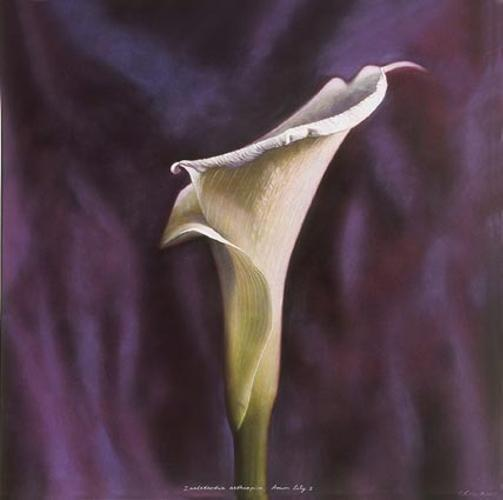

In [32]:
pil,tensor = process_image('image_04927.jpg')
tensor.shape
pil

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [33]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

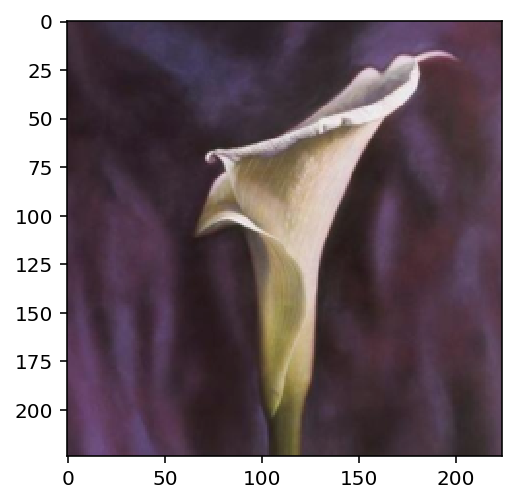

In [34]:
imshow(tensor)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [35]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

    model.eval()
    
    model.cpu()
    
    # load image as torch.Tensor
    _, image = process_image(image_path)

    # Un-squeeze returns a new tensor with a dimension of size one
    image = image.unsqueeze(0)

    # Disabling gradient calculation
    with torch.no_grad():
        output = model(image)
        top_prob, top_labels = torch.topk(output, topk)

        # Calculate the exponential
        top_prob = top_prob.exp()

    class_to_idx_inv = {model.class_to_idx[key]: int(key) for key, value in model.class_to_idx.items()}
    mapped_classes = []

    for label in top_labels.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])

    return top_prob.numpy()[0], mapped_classes

In [36]:
predict('image_04927.jpg',model)

NameError: name 'model' is not defined

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

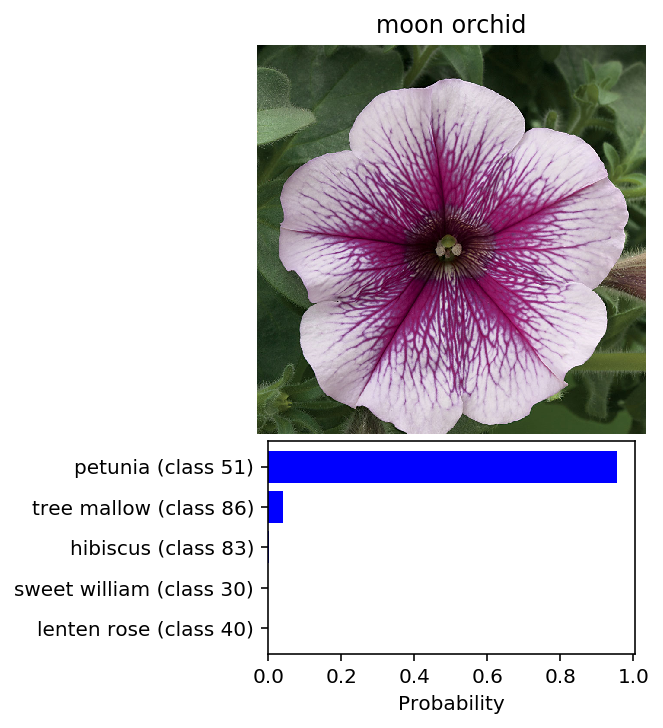

Correct prediction: False


In [51]:
# TODO: Display an image along with the top 5 classes after loading the model
model_loaded, _ = load_checkpoint('model_resnet18_pytorch_challenge.pt')

image_file1 = 'image_04903.jpg'
image_file2 = 'image_04913.jpg'
image_file3 = '51588-pk-p1.jpg'
image_file4 = 'image_07925.jpg'
correct_class1 = cat_to_name['20']
correct_class2 = cat_to_name['20']
correct_class3 = cat_to_name['7']
correct_class4 = cat_to_name['100']

top_prob, top_classes = predict(image_file3, model_loaded)

label = top_classes[0]

fig = plt.figure(figsize=(6,6))
sp_img = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
sp_prd = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_file3)
sp_img.axis('off')
sp_img.set_title(f'{correct_class3}')
sp_img.imshow(image)

labels = []
for class_idx in top_classes:
    labels.append(cat_to_name[str(class_idx)] + ' (class ' + str(class_idx) + ')')

yp = np.arange(5)
sp_prd.set_yticks(yp)
sp_prd.set_yticklabels(labels)
sp_prd.set_xlabel('Probability')
sp_prd.invert_yaxis()
sp_prd.barh(yp, top_prob, xerr=0, align='center', color='blue')

plt.show()
print(f'Correct prediction: {correct_class3 == cat_to_name[str(label)]}')